In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import analysis
from analysis import lin_cost, abs_cost, las_cost
from analysis import fit_linear, fit_lasso, fit_lasso_linear

# Data parameters

In [42]:
rng = np.random.RandomState(20170808)
n_data = 50
alpha = .1

X_cov = np.array([[1., 0., 0.],
                  [0., .6, .59],
                  [0., .59, .6]])
M = np.array([-.5, .75, 0.])
noise_std = .5

fontsize = 12

# Analysis

In [43]:
X, Y = analysis.sample_data(X_cov, M, noise_std, n_data, rng)

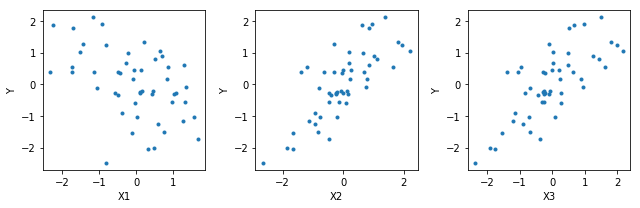

In [44]:
f, axes = plt.subplots(1, 3, figsize=(9, 3))
for ii, ax in enumerate(axes):
    ax.plot(X[:, ii], Y, '.')
    ax.set_ylabel('Y')
    ax.set_xlabel('X{}'.format(ii+1))
f.tight_layout()
plt.show()

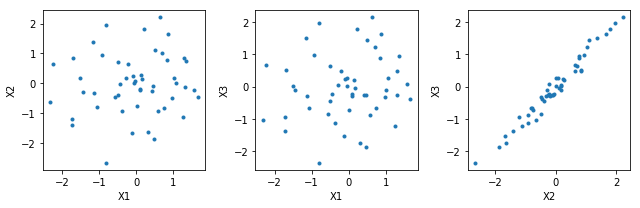

In [45]:
f, axes = plt.subplots(1, 3, figsize=(9, 3))
idx = 0
for ii in range(3):
    for jj in range(ii+1, 3):
        axes[idx].plot(X[:, ii], X[:, jj], '.')
        axes[idx].set_ylabel('X{}'.format(jj+1))
        axes[idx].set_xlabel('X{}'.format(ii+1))
        idx += 1
f.tight_layout()
plt.show()

In [46]:
lin_est = fit_linear(X, Y)
las_est = fit_lasso(X, Y, alpha)
laslin_est = fit_lasso_linear(X, Y, alpha)

In [47]:
n_pts = 100
limit = 1
locs = np.linspace(-limit, limit, n_pts)
M_grid = np.stack([a.ravel() for a in np.meshgrid(locs,
                                                  locs)]).T
M_grid = np.concatenate((M[0] * np.ones((n_pts**2, 1)), M_grid), axis=1)

In [48]:
lin_c = lin_cost(X, Y, M_grid).reshape(n_pts, n_pts)
abs_c = abs_cost(M_grid, alpha).reshape(n_pts, n_pts)
las_c = las_cost(X, Y, M_grid, alpha).reshape(n_pts, n_pts)

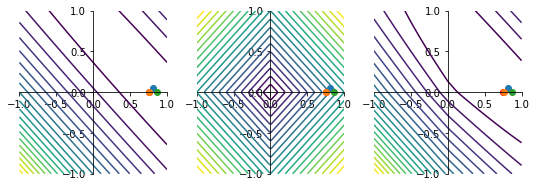

In [49]:
f, axes = plt.subplots(1, 3, figsize=(9, 3))

X_locs = M_grid.T[1].reshape(n_pts, n_pts)
Y_locs = M_grid.T[2].reshape(n_pts, n_pts)

for ax, data in zip(axes, [lin_c, abs_c, las_c]):
    ax.contour(X_locs, Y_locs, data, 20)
    ax.plot(M[1], M[2], 'ro')
    ax.plot(lin_est[1], lin_est[2], 'o')
    ax.plot(las_est[1], las_est[2], 'o')
    ax.plot(laslin_est[1], laslin_est[2], 'o')
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_yticks(np.linspace(-1, 1, 5))

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

In [50]:
n_trials = 10000
lin_m = np.zeros((n_trials, 2))
las_m = np.zeros((n_trials, 2))
laslin_m = np.zeros((n_trials, 2))
for ii in range(n_trials):
    X, Y = analysis.sample_data(X_cov, M, noise_std, n_data, rng)
    lin_m[ii] = fit_linear(X, Y)[1:]
    las_m[ii] = fit_lasso(X, Y, alpha)[1:]
    laslin_m[ii] = fit_lasso_linear(X, Y, alpha)[1:]

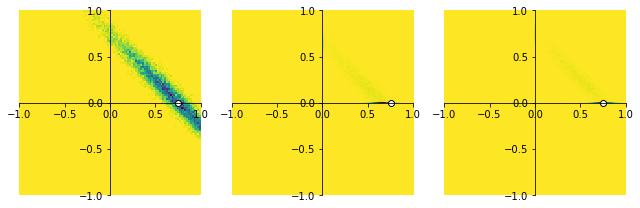

In [51]:
f, axes = plt.subplots(1, 3, figsize=(9, 3))

for ax, data in zip(axes, [lin_m, las_m, laslin_m]):
    ax.hist2d(data[:,0], data[:,1], bins=np.linspace(-1, 1, 100), cmap='viridis_r')

for ax in axes:
    ax.plot(M[1], M[2], 'wo', markeredgecolor='k')
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_yticks(np.linspace(-1, 1, 5))
f.tight_layout()
plt.show()

# Cross-validation analysis

In [52]:
alphas = np.logspace(-8, 0, 16)
cv_iters = 100

costs = np.zeros((cv_iters, alphas.size, 3))

for ii in range(cv_iters):
    X, Y = analysis.sample_data(X_cov, M, noise_std, n_data, rng)
    Xh, Yh = analysis.sample_data(X_cov, M, noise_std, n_data, rng)
    for jj, a in enumerate(alphas):
        costs[ii, jj, 0] = lin_cost(Xh, Yh, fit_lasso(X, Y, a))
        costs[ii, jj, 1] = lin_cost(Xh, Yh, fit_lasso_linear(X, Y, a))
    costs[ii, :, 2] = lin_cost(Xh, Yh, fit_linear(X, Y))

median_costs = np.median(costs, axis=0)
best_idxs = median_costs.argmin(axis=0)

In [53]:
n_trials = 10000
lin_m = np.zeros((n_trials, 2))
las_m = np.zeros((n_trials, 2))
laslin_m = np.zeros((n_trials, 2))
for ii in range(n_trials):
    X, Y = analysis.sample_data(X_cov, M, noise_std, n_data, rng)
    lin_m[ii] = fit_linear(X, Y)[1:]
    las_m[ii] = fit_lasso(X, Y, alphas[best_idxs[0]])[1:]
    laslin_m[ii] = fit_lasso_linear(X, Y, alphas[best_idxs[1]])[1:]

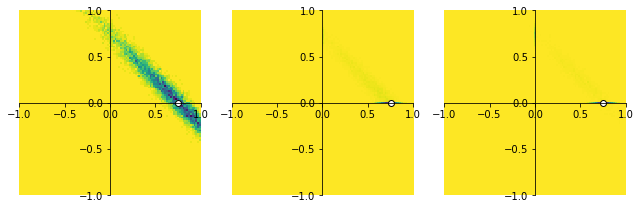

In [54]:
f, axes = plt.subplots(1, 3, figsize=(9, 3))

for ax, data in zip(axes, [lin_m, las_m, laslin_m]):
    ax.hist2d(data[:,0], data[:,1], bins=np.linspace(-1, 1, 100), cmap='viridis_r')

for ax in axes:
    ax.plot(M[1], M[2], 'wo', markeredgecolor='k')
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_yticks(np.linspace(-1, 1, 5))
f.tight_layout()
plt.show()